# 2024 CITS4012 Project

# Readme
1. Enable access to Google Drive.
2. Replace the file path for the data in the code with the correct one.
- Note: all code above the "Train and Evaluate Models" section defines the functions required for training and evaluation.
- Note: all code below the "Train and Evaluate Models" section executes the training process, evaluates the models by returning the accuracy, plots the graphs and visualise the attention weights for each model.

# 1. Dataset Processing

## Importing Libraries

In [1]:
import re
import json
import time
import math
import spacy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

## Loading Datasets

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the training data
with open('/content/drive/MyDrive/data/train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
with open('/content/drive/MyDrive/data/test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
with open('/content/drive/MyDrive/data/val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist()
training_a = train_data['aspect'].tolist()
training_y = train_data['polarity'].tolist()
val_x = val_data['sentence'].tolist()
val_a = val_data['aspect'].tolist()
val_y = val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [44]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7090
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

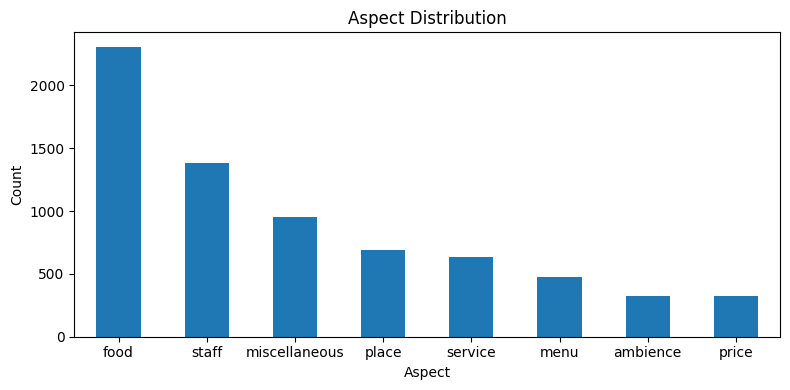

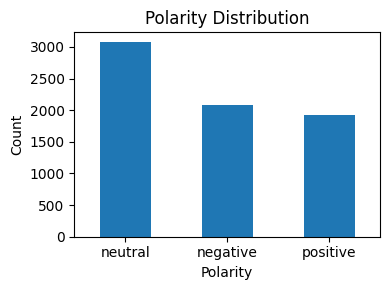

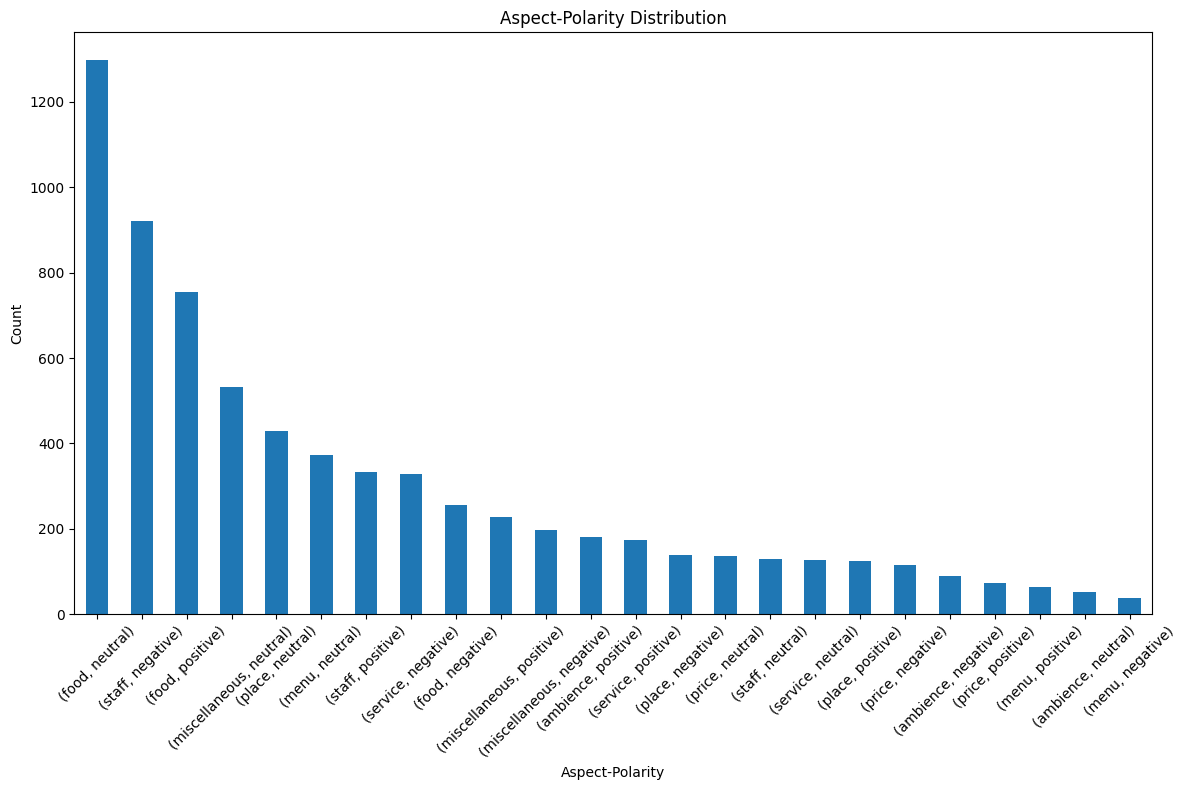

In [45]:
# Function to plot distribution bar graphs
def plot_distribution(figsize, distribution, title, xlabel, rotation=0):
    plt.figure(figsize=figsize)
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot Aspect Distribution
plot_distribution((8, 4), aspect_distribution, 'Aspect Distribution', 'Aspect')
# Plot Polarity Distribution
plot_distribution((4, 3), polarity_distribution, 'Polarity Distribution', 'Polarity')
# Plot Aspect-Polarity Distribution
plot_distribution((12, 8), aspect_polarity_freq, 'Aspect-Polarity Distribution', 'Aspect-Polarity', 45)

## Data Preprocessing

In [7]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 469.7 kB/s eta 0:00:28
     --------------------------------------- 0.1/12.8 MB 950.9 kB/s eta 0:00:14
      --------------------------------------- 0.3/12.8 MB 1.4 MB/s eta 0:00:10
     - -------------------------------------- 0.5/12.8 MB 2.0 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 2.5 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 2.9 MB/s eta 0:00:05
     --- ------------------------------------ 1.3/12.8 MB 3.2 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.5 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.6 MB/s eta 0:00:04
     ----- ---------------------------------- 1.9/12.8 MB 3.5 M

In [46]:
# Spacy
nlp = spacy.load("en_core_web_sm")

# Remove certain words from the stop words list
custom_stop_words = [
    "not", "no", "never", "neither", "nor",
    "nobody", "nothing", "nowhere", "none", "cannot"
]

for a in custom_stop_words:
    nlp.vocab[a].is_stop = False

# Perform Stopwords Removal, Lemmatisation and Tokenisation
def spacy_processing(x):
    doc = nlp(x)
    x = [word.lemma_ for word in doc if not word.is_stop]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

In [47]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)    # Remove punctuation
        sentence = re.sub(r"\s+", " ", sentence)        # Remove extra spaces
        tokens = spacy_processing(sentence)             # Remove stopwords / Lemmatisation / Tokenise
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)
val_x_token = preprocess_data(val_x)

# Function to append aspect to the end of sentence
def append_aspect(token_list, aspect_list, has_sep):
    output = []
    for tokens, aspect in zip(token_list, aspect_list):
        if has_sep:
            new_tokens = tokens + ['<SEP>'] + [aspect]
        else:
            new_tokens = tokens + [aspect]
        output.append(new_tokens)
    return output

# Append aspect to end of sentence
train_xa_sep_token = append_aspect(train_x_token, training_a, has_sep=True)
test_xa_sep_token = append_aspect(test_x_token, test_a, has_sep=True)
val_xa_sep_token = append_aspect(val_x_token, val_a, has_sep=True)

KeyboardInterrupt: 

## Create Word Vocabulary

In [ ]:
# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<SEP>': 0, '<PAD>': 1}
review = train_x_token + test_x_token + val_x_token
review_aspect_sep = train_xa_sep_token + test_xa_sep_token + val_xa_sep_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]
MAX_LENGTH = len(max(review, key=len))                # Maximum length of a sentence
MAX_SEP_LENGTH = len(max(review_aspect_sep, key=len)) # Maximum length of a sentence after appending aspect with separator

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
word_list = list(word_to_idx.keys())
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}
polarity_list = list(polarity_to_idx.keys())
num_polarities = len(polarity_to_idx)

## Convert Words to Index form

In [ ]:
# Function to convert list of tokens to list of indices (with paddings)
def list_to_index(token_list, word_to_idx, max_seq_length):
    idx_list = []
    for tokens in token_list:
        padded = tokens + ['<PAD>'] * (max_seq_length - len(tokens))
        idx_list.append([word_to_idx[token] for token in padded])
    return idx_list

# Function to convert list of strings to list of indices
def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Function to prepare index lists for datasets
def prepare_index_lists(x_token, a, y, xa_sep_token):
    x_idx = list_to_index(x_token, word_to_idx, MAX_LENGTH)
    a_idx = string_to_index(a, word_to_idx)
    y_idx = string_to_index(y, polarity_to_idx)
    xa_idx = list_to_index(xa_sep_token, word_to_idx, MAX_SEP_LENGTH)
    return x_idx, a_idx, y_idx, xa_idx

# Token index lists for training data (with paddings)
train_x_idx, train_a_idx, train_y_idx, train_xa_idx = prepare_index_lists(
    train_x_token, training_a, training_y, train_xa_sep_token)

# Token index lists for test data (with paddings)
test_x_idx, test_a_idx, test_y_idx, test_xa_idx = prepare_index_lists(
    test_x_token, test_a, test_y, test_xa_sep_token)

# Token index lists for validation data (with paddings)
val_x_idx, val_a_idx, val_y_idx, val_xa_idx = prepare_index_lists(
    val_x_token, val_a, val_y, val_xa_sep_token)

## Pretrained Word Embeddings from Glove

In [12]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100
glove_model = api.load("glove-twitter-100")
glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

# 2. Model Implementation

## Model 1 Architecture

In [ ]:
class Model1(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention, has_aspect='True'):
        super(Model1, self).__init__()
        self.has_aspect = has_aspect
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        if self.attention_type == ATTN_NONE:
            self.linear = nn.Linear(self.hidden_size, self.output_size)
        else:
            self.linear = nn.Linear(self.hidden_size*2, self.output_size)

    # Attention mechanism
    def attention(self, query, key, masking):
        if self.attention_type == ATTN_NONE:    # No attention
            output = F.softmax(self.linear(key.squeeze()), dim=1)
            return output, _
        elif self.attention_type == ATTN_DOT:   # Dot product attention
            attn_weights = torch.bmm(query, key.permute(1, 2, 0))
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key.permute(1, 2, 0)) * scale
        # Apply masking to ignore padding
        attn_weights.masked_fill_(masking.unsqueeze(2), float('-inf'))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output, attn_weights
    
    # Forward propagation
    def forward(self, input, _):
        sentence_embeddings = self.embedding(input)
        outputs, (hidden, cell) = self.lstm(sentence_embeddings)
        # outputs = [batch_size, seq_length, hidden_size]
        # hidden  = [num_layers=1, batch_size, hidden_size]
        masking = (input==1)
        output, attn_weights = self.attention(outputs, hidden, masking)
        return output, attn_weights

## Model 2 Architecture

In [ ]:
class Model2(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention):
        super(Model2, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, batch_first=True)
        if self.attention_type == ATTN_NONE:
            self.linear = nn.Linear(self.hidden_size, self.output_size)
        else:
            self.linear = nn.Linear(self.hidden_size*4, self.output_size)
        
    # Attention mechanism
    def attention(self, query, key, masking):
        if self.attention_type == ATTN_NONE:    # No attention
            output = F.softmax(self.linear(key.squeeze()), dim=1)
            return output, _
        elif self.attention_type == ATTN_DOT:   # Dot product attention
            attn_weights = torch.bmm(query, key.permute(1, 2, 0))
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key.permute(1, 2, 0)) * scale
        # Apply masking to ignore padding
        attn_weights.masked_fill_(masking.unsqueeze(2), float('-inf'))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output, attn_weights

    # Forward propagation
    def forward(self, input, aspect):
        sentence_embeddings = self.embedding(input)
        aspect_embeddings = self.embedding(aspect)
        reshape_aspect_embeddings = aspect_embeddings.view(self.batch_size, 1, self.hidden_size)
        reshape_aspect_embeddings = reshape_aspect_embeddings.expand(self.batch_size, MAX_LENGTH, self.hidden_size)
        # Concatenate sentence embeddings with aspect embeddings
        embedded = torch.cat((sentence_embeddings, reshape_aspect_embeddings), dim=-1)
        outputs, (hidden, cell) = self.lstm(embedded)
        # Concatenate aspect embeddings with sentence hidden representations
        outputs = torch.cat((outputs, reshape_aspect_embeddings), dim=-1)
        hidden = torch.cat((hidden, aspect_embeddings.permute(1, 0, 2)), dim=-1)
        masking = (input==1)
        output, attn_weights = self.attention(outputs, hidden, masking)
        return output, attn_weights

## Model 3 Architecture

In [ ]:
class Model3(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention):
        super(Model3, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm_aspect = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm_input = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4, self.output_size)
        
    # Attention mechanism
    def attention(self, query, key, masking=None):
        if self.attention_type == ATTN_DOT:     # Dot product attention
            attn_weights = torch.bmm(query, key)
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key) * scale
        # Apply masking to ignore padding (only for input)
        if masking is not None:
            attn_weights.masked_fill_(masking.unsqueeze(2), float('-inf'))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(2)), dim=1)
        return concat_output, attn_weights

    # Forward propagation
    def forward(self, input, aspect):
        input_length = torch.sum(input!=1, dim=1)
        input_embeddings = self.embedding(input)
        aspect_embeddings = self.embedding(aspect)
        masking = (input==1)
        
        # LSTM for input and aspect
        input, (_, _) = self.lstm_input(input_embeddings)
        aspect, (_, _) = self.lstm_aspect(aspect_embeddings)
        
        # Average values for aspect and input
        aspect_pool = torch.mean(aspect, dim=1)
        input_pool = torch.sum(input, dim=1)
        input_pool = torch.div(input_pool, input_length.view(input_length.size(0), 1))

        # Interactive attention
        input_final, attn_weights = self.attention(input, aspect_pool.unsqueeze(2), masking)
        aspect_final, _ = self.attention(aspect, input_pool.unsqueeze(2))
        # attn_weights for aspect not used = 1.0 for all (only one aspect word)
        
        output = torch.cat((input_final, aspect_final), dim=1)
        output = F.log_softmax(self.linear(output), dim=1)
        return output, attn_weights

## Helper Functions for Training
- asMinutes() : Convert time to minutes
- timeSince() : Calculate time since last checkpoint
- prepare_batch() : Prepare batch tensor data for training

In [ ]:
# Function to get time elapsed during training
# Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to prepare data in batches
def prepare_batch(sentences, aspects, polarities, batch_size):
    data = []
    for i in range(len(sentences)):
        x_tensor = torch.LongTensor(sentences[i]).to(device)
        a_tensor = torch.LongTensor([aspects[i]]).to(device)
        y_tensor = torch.LongTensor([polarities[i]]).to(device)
        data.append((x_tensor, a_tensor, y_tensor))
    dataloader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    return dataloader

## Function to Train Model
- train() : Train model on training data in batches
- plot_graph() : Plot loss or accuracy graph over epochs
- Note: have to run the functions under "3. Testing and Evaluation" for Accuracy graph visualisation

In [ ]:
# Function to train model
def train(model, batches, batch_size=32, learning_rate=0.001, num_epochs=20,
          print_interval=1, plot_interval=1, accuracy_graph=False):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    plot_avg_losses, plot_accuracy = [], []
    print_total_loss, plot_total_loss = 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        for i, batch in enumerate(batches):
            (inputs, aspects, targets) = batch
            
            model.train()
            optimizer.zero_grad()
            
            outputs, _ = model(inputs, aspects)
            loss = criterion(outputs, targets.squeeze())
            
            # Backpropogation
            loss.backward()
            optimizer.step()
            
            print_total_loss += loss.item()
            plot_total_loss += loss.item()

        if epoch % print_interval == 0:
            print_avg_loss = print_total_loss / ((i+1)*print_interval)
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_total_loss = 0

        if epoch % plot_interval == 0:
            # Calculate average loss over plot interval
            plot_avg_loss = plot_total_loss / ((i+1)*plot_interval)
            plot_avg_losses.append(plot_avg_loss)
            plot_total_loss = 0

            # Calculate accuracy on validation set
            if accuracy_graph:
                accuracy = evaluate(model, batch_size, is_test=False)
                plot_accuracy.append(accuracy)

    return model, plot_avg_losses, plot_accuracy

# Function to plot loss or accuracy graph over epochs
def plot_graph(num_epochs, interval, plot_data, title, metric):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs+1, interval), plot_data)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

# 3. Testing and Evaluation

## Functions to Visualise Attention Weights
- plot_attention() : Plot attention weights for a given sentence

In [ ]:
# Define custom colormap with Blue as highest values and white as lowest values
colors = [(1, 1, 1), (0.2, 0.4, 1)]  # White to Blue
cmap_name = 'custom_blue_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Function to plot attention weights for a sentence
def plot_attention(words, attention_weights, sentence, aspect, pred_polarity, true_polarity):
    # Create figure and axis
    size = len(words)
    fig, ax = plt.subplots(figsize=(size, 2))
    max_w = max(attention_weights)
    norm = plt.Normalize(vmin=0, vmax=max_w)

    # Plot each word with attention weight as colored box
    for i, (word, weight) in enumerate(zip(words, attention_weights)):
        # Plot word
        ax.text(i, 0.5, word, ha='center', va='center', fontsize=12)
        ax.text(i, 0.8, round(weight, 3), ha='center', va='center', color='black', fontsize=12)
        # Plot colored box above word
        color = custom_cmap(norm(weight))
        rect = plt.Rectangle((i - 0.5, 0.6), 1, 0.4, color=color, ec='black')

        ax.add_patch(rect)

    # Set x-axis and y-axis properties
    ax.set_xlim(-0.5, size - 0.5)

    # Remove x-axis and y-axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide ticks on x-axis and y-axis
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(f'Aspect: {aspect} | Predicted Polarity: {pred_polarity} | True Polarity: {true_polarity}', fontsize=14)

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    ax.text(-1, 0.2, ', '.join(words), ha='left', va='center', fontsize=12)
    ax.text(-1, 0, sentence, ha='left', va='center', fontsize=12)
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.05, right=0.95)

    # Show plot
    plt.show()

## Function to Evaluate Model
- evaluate_batch() : Count the number of correct predictions in a batch
- evaluate() : Evaluate model on val/test data and return accuracy
<a id="evaluation"></a>

In [ ]:
# Function to get model's prediction on test data
def evaluate_batch(model, inputs, aspects, targets):
    correct = 0
    predicted_polarities = []
    outputs, attn_weights = model(inputs, aspects)
    _, topi = outputs.data.topk(1)
    for output, target in zip(topi, targets):
        predicted = polarity_list[output.item()]
        actual = polarity_list[target.item()]
        predicted_polarities.append(predicted)
        if predicted == actual:
            correct += 1
    return correct, attn_weights, predicted_polarities

# Function to calculate model accuracy on test data
def evaluate(model, batch_size, is_test=True):
    model.eval()
    with torch.no_grad():
        # Prepare batches based on integration type
        if isinstance(model, Model1):
            sentences = test_xa_idx if is_test else val_xa_idx
        elif isinstance(model, Model2) or isinstance(model, Model3):
            sentences = test_x_idx if is_test else val_x_idx
        aspects = test_a_idx if is_test else val_a_idx
        polarities = test_y_idx if is_test else val_y_idx
        data_batches = prepare_batch(sentences, aspects, polarities, batch_size)

        # Calculate accuracy
        correct = 0
        for (inputs, aspects, targets) in data_batches:
            batch_correct, _, _ = evaluate_batch(model, inputs, aspects, targets)
            correct += batch_correct
        accuracy = correct / len(test_data)
    return accuracy

# Train and Evaluate Models

## Selected Hyperparameters

In [20]:
# Different attention mechanisms
ATTN_NONE     = 'no_attention'
ATTN_DOT      = 'dot_product'
ATTN_SCALE    = 'scaled_dot_product'

# Set hyperparameters
num_epochs     = 20
print_interval = 1
plot_interval  = 1
batch_size     = 32
hidden_size    = 100
learning_rate  = 0.001
attention_type = ATTN_DOT

# Prepare batches for training
batches = prepare_batch(train_x_idx, train_a_idx, train_y_idx, batch_size)
sep_batches = prepare_batch(train_xa_idx, train_a_idx, train_y_idx, batch_size)

## Train and Evaluate Model 0 (No aspect integration)

0m 1s (- 0m 29s) Epoch [1/20] Loss: 1.0186
0m 3s (- 0m 31s) Epoch [2/20] Loss: 0.9570
0m 5s (- 0m 30s) Epoch [3/20] Loss: 0.9124
0m 7s (- 0m 30s) Epoch [4/20] Loss: 0.8758
0m 9s (- 0m 27s) Epoch [5/20] Loss: 0.8388
0m 11s (- 0m 26s) Epoch [6/20] Loss: 0.8125
0m 13s (- 0m 25s) Epoch [7/20] Loss: 0.7918
0m 15s (- 0m 23s) Epoch [8/20] Loss: 0.7764
0m 17s (- 0m 21s) Epoch [9/20] Loss: 0.7652
0m 19s (- 0m 19s) Epoch [10/20] Loss: 0.7535
0m 21s (- 0m 17s) Epoch [11/20] Loss: 0.7478
0m 23s (- 0m 15s) Epoch [12/20] Loss: 0.7403
0m 25s (- 0m 13s) Epoch [13/20] Loss: 0.7372
0m 27s (- 0m 11s) Epoch [14/20] Loss: 0.7310
0m 29s (- 0m 9s) Epoch [15/20] Loss: 0.7310
0m 31s (- 0m 7s) Epoch [16/20] Loss: 0.7256
0m 32s (- 0m 5s) Epoch [17/20] Loss: 0.7246
0m 34s (- 0m 3s) Epoch [18/20] Loss: 0.7232
0m 36s (- 0m 1s) Epoch [19/20] Loss: 0.7263
0m 38s (- 0m 0s) Epoch [20/20] Loss: 0.7210
Accuracy for Model 0: 0.4617


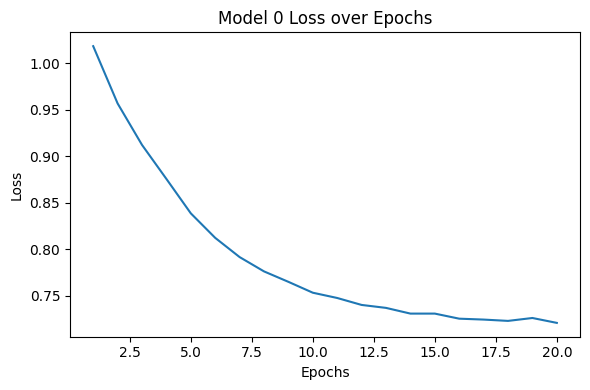

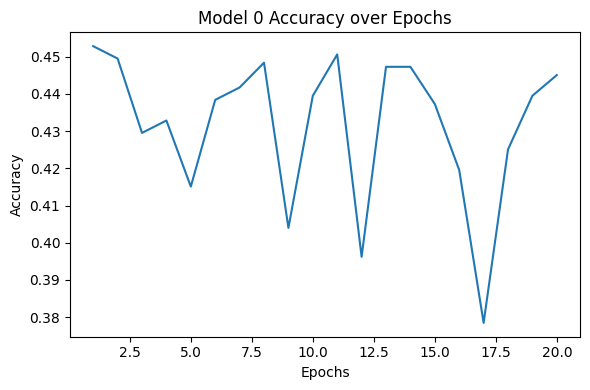

In [31]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

model0 = Model1(hidden_size, num_polarities, batch_size, embedding, attention_type, has_aspect=False).to(device)
model0, plot_avg_losses0, plot_accuracy0 = train(model0, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=True)

accuracy0 = evaluate(model0, batch_size)
print(f"Accuracy for Model 0: {accuracy0:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses0, 'Model 0 Loss over Epochs', 'Loss')
plot_graph(num_epochs, plot_interval, plot_accuracy0, 'Model 0 Accuracy over Epochs', 'Accuracy')

## Train and Evaluate Model 1

0m 1s (- 0m 29s) Epoch [1/20] Loss: 0.9637
0m 3s (- 0m 29s) Epoch [2/20] Loss: 0.8247
0m 5s (- 0m 29s) Epoch [3/20] Loss: 0.7483
0m 7s (- 0m 29s) Epoch [4/20] Loss: 0.6907
0m 9s (- 0m 28s) Epoch [5/20] Loss: 0.6332
0m 12s (- 0m 28s) Epoch [6/20] Loss: 0.5785
0m 14s (- 0m 26s) Epoch [7/20] Loss: 0.5215
0m 16s (- 0m 24s) Epoch [8/20] Loss: 0.4598
0m 18s (- 0m 22s) Epoch [9/20] Loss: 0.4062
0m 19s (- 0m 19s) Epoch [10/20] Loss: 0.3505
0m 21s (- 0m 17s) Epoch [11/20] Loss: 0.3041
0m 23s (- 0m 15s) Epoch [12/20] Loss: 0.2669
0m 25s (- 0m 13s) Epoch [13/20] Loss: 0.2304
0m 26s (- 0m 11s) Epoch [14/20] Loss: 0.1974
0m 28s (- 0m 9s) Epoch [15/20] Loss: 0.1723
0m 30s (- 0m 7s) Epoch [16/20] Loss: 0.1469
0m 31s (- 0m 5s) Epoch [17/20] Loss: 0.1327
0m 33s (- 0m 3s) Epoch [18/20] Loss: 0.1123
0m 35s (- 0m 1s) Epoch [19/20] Loss: 0.1050
0m 36s (- 0m 0s) Epoch [20/20] Loss: 0.1081
Accuracy for Model 1: 0.6393


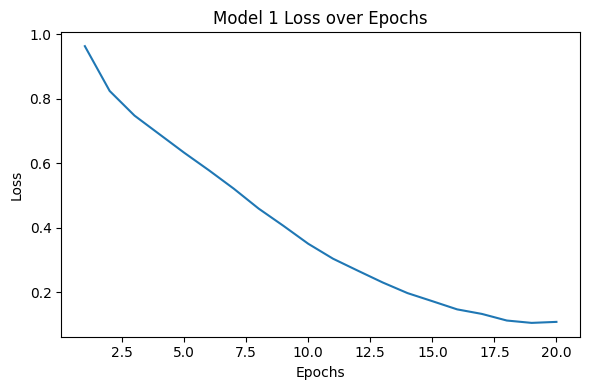

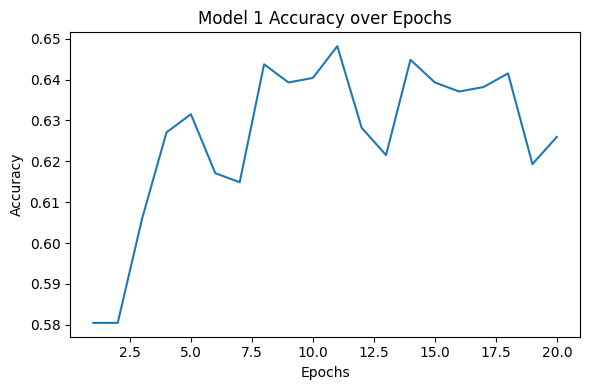

In [30]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

model1 = Model1(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model1, plot_avg_losses1, plot_accuracy1 = train(model1, sep_batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=True)

accuracy1 = evaluate(model1, batch_size)
print(f"Accuracy for Model 1: {accuracy1:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses1, 'Model 1 Loss over Epochs', 'Loss')
plot_graph(num_epochs, plot_interval, plot_accuracy1, 'Model 1 Accuracy over Epochs', 'Accuracy')

## Train and Evaluate Model 2

0m 1s (- 0m 27s) Epoch [1/20] Loss: 0.8804
0m 3s (- 0m 31s) Epoch [2/20] Loss: 0.7714
0m 5s (- 0m 31s) Epoch [3/20] Loss: 0.6858
0m 7s (- 0m 29s) Epoch [4/20] Loss: 0.6045
0m 9s (- 0m 27s) Epoch [5/20] Loss: 0.5138
0m 11s (- 0m 25s) Epoch [6/20] Loss: 0.4320
0m 12s (- 0m 23s) Epoch [7/20] Loss: 0.3527
0m 14s (- 0m 21s) Epoch [8/20] Loss: 0.2775
0m 16s (- 0m 20s) Epoch [9/20] Loss: 0.2153
0m 18s (- 0m 18s) Epoch [10/20] Loss: 0.1732
0m 20s (- 0m 16s) Epoch [11/20] Loss: 0.1229
0m 21s (- 0m 14s) Epoch [12/20] Loss: 0.0857
0m 23s (- 0m 12s) Epoch [13/20] Loss: 0.0796
0m 25s (- 0m 10s) Epoch [14/20] Loss: 0.0832
0m 27s (- 0m 9s) Epoch [15/20] Loss: 0.0423
0m 28s (- 0m 7s) Epoch [16/20] Loss: 0.0265
0m 30s (- 0m 5s) Epoch [17/20] Loss: 0.0219
0m 32s (- 0m 3s) Epoch [18/20] Loss: 0.0322
0m 34s (- 0m 1s) Epoch [19/20] Loss: 0.0139
0m 35s (- 0m 0s) Epoch [20/20] Loss: 0.0086
Accuracy for Model 2: 0.6937


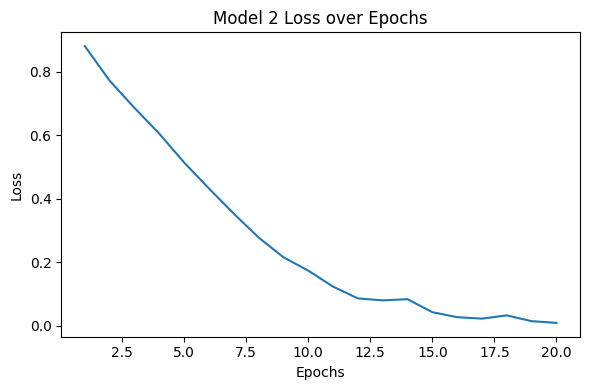

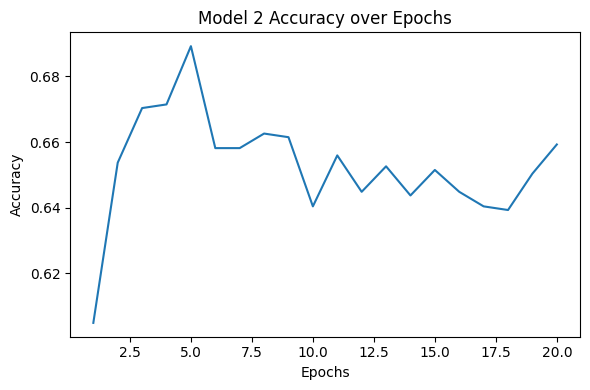

In [23]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

model2 = Model2(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model2, plot_avg_losses2, plot_accuracy2 = train(model2, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=True)

accuracy2 = evaluate(model2, batch_size)
print(f"Accuracy for Model 2: {accuracy2:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses2, 'Model 2 Loss over Epochs', 'Loss')
plot_graph(num_epochs, plot_interval, plot_accuracy2, 'Model 2 Accuracy over Epochs', 'Accuracy')

## Train and Evaluate Model 3

0m 1s (- 0m 37s) Epoch [1/20] Loss: 0.8736
0m 4s (- 0m 37s) Epoch [2/20] Loss: 0.7715
0m 6s (- 0m 36s) Epoch [3/20] Loss: 0.6913
0m 8s (- 0m 34s) Epoch [4/20] Loss: 0.5928
0m 11s (- 0m 33s) Epoch [5/20] Loss: 0.4944
0m 13s (- 0m 30s) Epoch [6/20] Loss: 0.3894
0m 15s (- 0m 28s) Epoch [7/20] Loss: 0.2960
0m 17s (- 0m 26s) Epoch [8/20] Loss: 0.2133
0m 19s (- 0m 24s) Epoch [9/20] Loss: 0.1459
0m 22s (- 0m 22s) Epoch [10/20] Loss: 0.1107
0m 25s (- 0m 21s) Epoch [11/20] Loss: 0.0817
0m 28s (- 0m 18s) Epoch [12/20] Loss: 0.0543
0m 30s (- 0m 16s) Epoch [13/20] Loss: 0.0375
0m 32s (- 0m 14s) Epoch [14/20] Loss: 0.0244
0m 35s (- 0m 11s) Epoch [15/20] Loss: 0.0152
0m 37s (- 0m 9s) Epoch [16/20] Loss: 0.0157
0m 39s (- 0m 7s) Epoch [17/20] Loss: 0.0506
0m 42s (- 0m 4s) Epoch [18/20] Loss: 0.0298
0m 44s (- 0m 2s) Epoch [19/20] Loss: 0.0215
0m 46s (- 0m 0s) Epoch [20/20] Loss: 0.0103
Accuracy for Model 3: 0.7059


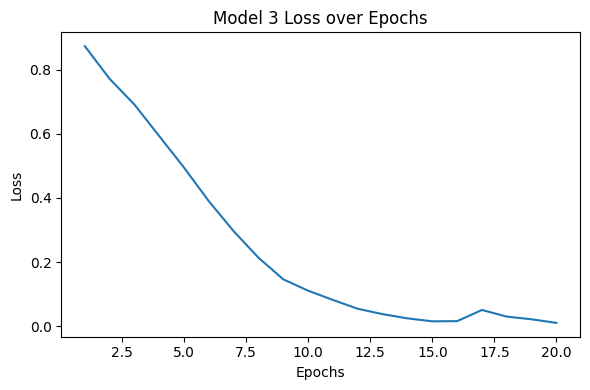

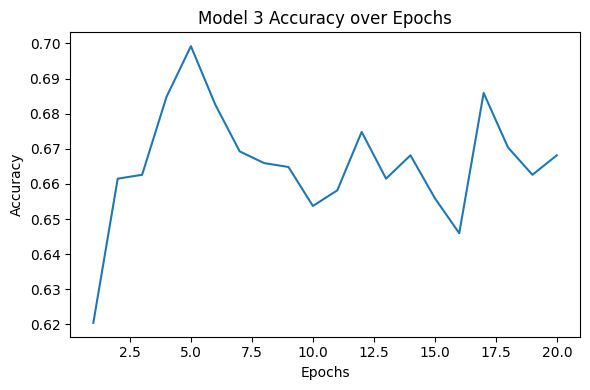

In [29]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

model3 = Model3(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model3, plot_avg_losses3, plot_accuracy3 = train(model3, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=True)

accuracy3 = evaluate(model3, batch_size)
print(f"Accuracy for Model 3: {accuracy3:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses3, 'Model 3 Loss over Epochs', 'Loss')
plot_graph(num_epochs, plot_interval, plot_accuracy3, 'Model 3 Accuracy over Epochs', 'Accuracy')

## Visualisation of Attention Weights

In [42]:
# Function to append data to the list according to given indices
def append_data(model, indices, data):
    for idx in indices:
        if isinstance(model, Model1):
            x_tensor = torch.LongTensor(test_xa_idx[idx]).to(device)
        elif isinstance(model, Model2) or isinstance(model, Model3):
            x_tensor = torch.LongTensor(test_x_idx[idx]).to(device)
        a_tensor = torch.LongTensor([test_a_idx[idx]]).to(device)
        y_tensor = torch.LongTensor([test_y_idx[idx]]).to(device)
        data.append((x_tensor, a_tensor, y_tensor))
    return data

# Function to prepare custom batch for visualisation
def prepare_custom_batch(model, indices, batch_size):
    data = append_data(model, indices, [])
    remaining_indices = list(range(len(test_x)))
    remaining_indices = [i for i in remaining_indices if i not in indices]
    batch_indices = np.random.choice(remaining_indices, size=batch_size-len(indices), replace=True)
    data = append_data(model, batch_indices, data)

    custom_batch = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
    return custom_batch

# Function to visualise the attention weights for a sentence
def visualise_sentence(model, indices, batch_size):
    custom_size = len(indices)
    reviews = [test_x[i] for i in indices]
    dataset = prepare_custom_batch(model, indices, batch_size)
    sentences, aspects, polarities = list(dataset)[0]
    words = [[idx_to_word[i] for i in sentence.tolist() if i != 1] for sentence in sentences[:custom_size]]
    _, attn_weights, pred_polarities = evaluate_batch(model, sentences, aspects, polarities)
    weights = [w.tolist() for w in attn_weights[:custom_size]]
    outputs = pred_polarities[:custom_size]
    aspects = [idx_to_word[aspects[i].item()] for i in range(custom_size)]
    targets = [idx_to_polarity[polarities[i].item()] for i in range(custom_size)]
    for i in range(custom_size):
        plot_attention(words[i], weights[i], reviews[i], aspects[i], outputs[i], targets[i])
        
# Test sample instances
indices = [2, 3, 528, 529, 530, 120, 121, 122, 123]

In [43]:
# Visualise the attention weights for the sample instances for Model 1
print("Visualising Attention Weights for Model 1:")
visualise_sentence(model1, indices, batch_size)

Visualising Attention Weights for Model 1:


UnboundLocalError: cannot access local variable 'x_tensor' where it is not associated with a value

Visualising Attention Weights for Model 2:


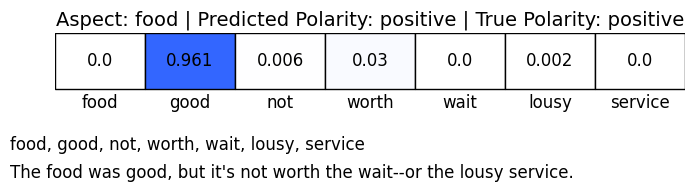

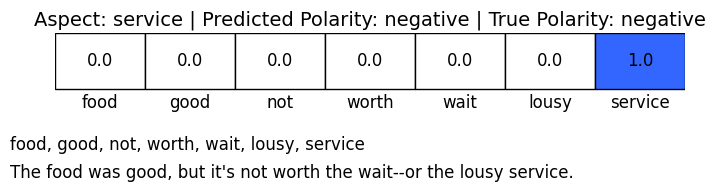

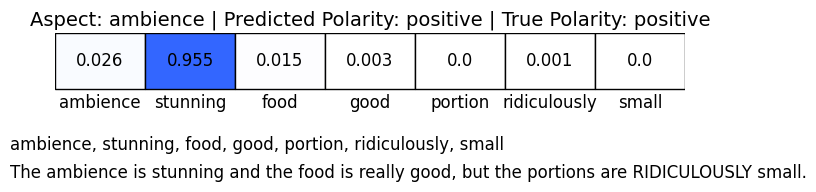

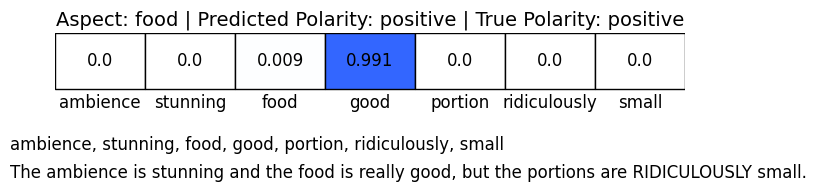

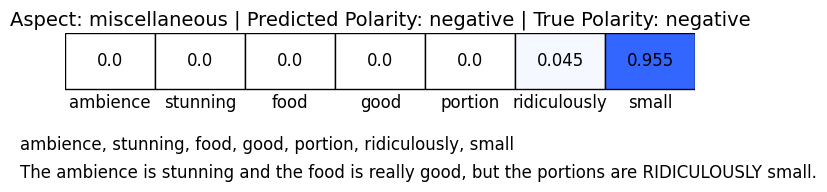

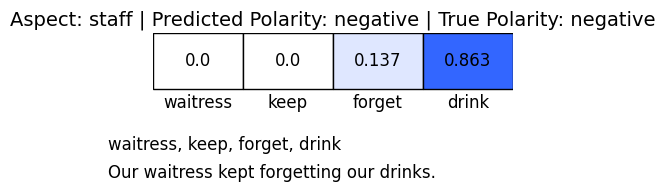

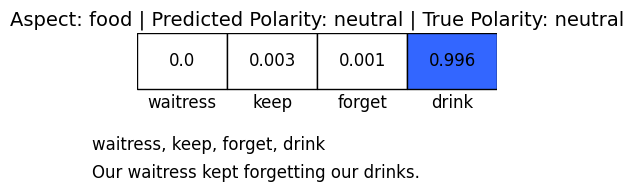

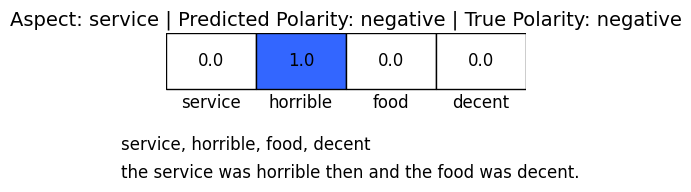

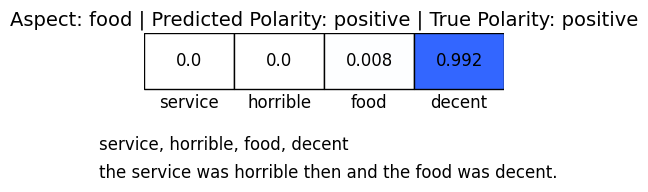

In [ ]:
# Visualise the attention weights for the sample instances for Model 2
print("Visualising Attention Weights for Model 2:")
visualise_sentence(model2, indices, batch_size)

Visualising Attention Weights for Model 3:


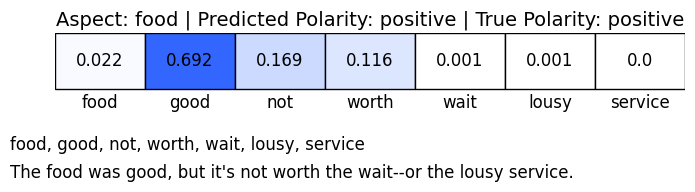

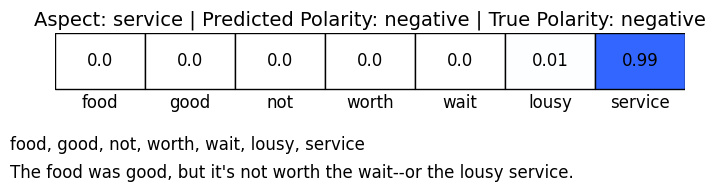

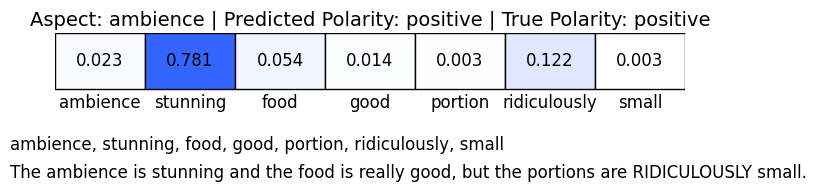

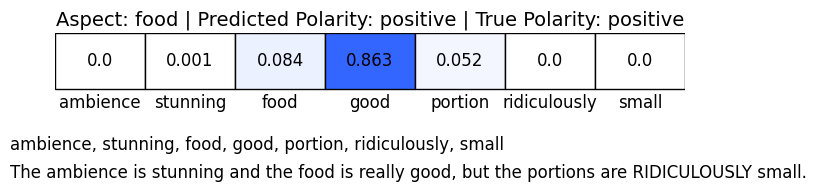

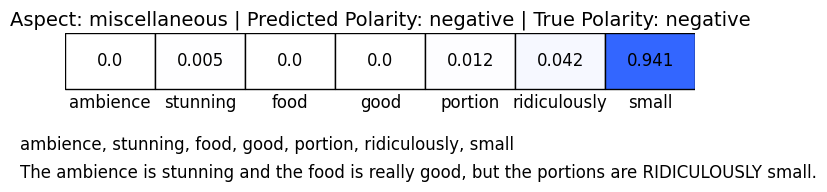

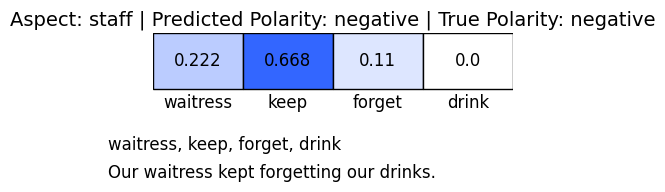

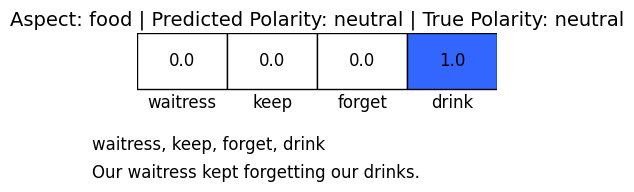

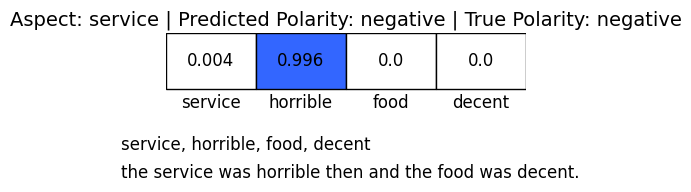

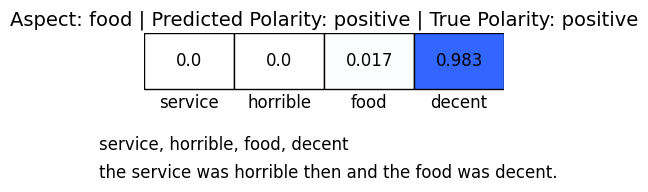

In [ ]:
# Visualise the attention weights for the sample instances for Model 2
print("Visualising Attention Weights for Model 3:")
visualise_sentence(model3, indices, batch_size)